In [1]:
# import libraries
import scipy.stats as stats
from statsmodels.stats import weightstats
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
np.random.seed(42)  # for producibility 

In [57]:
# import location and price df for random, remove na , and median 
df_median = pd.read_pickle('data/median_price.pkl')
df_random = pd.read_pickle('data/random_price.pkl')
df_na = pd.read_pickle('data/na_remove.pkl')

In [17]:
df_na.head(2)

,categories,price,rating,review_count,Lat,Lon,state
0,Salad|Seafood|American (Traditional),2,3.5,372,38.997397,-77.026797,MD
1,Pizza|American (New)|Salad,2,3.5,192,38.919506,-77.224311,VA


In [58]:
# define a function split into 3 groups DC, MD, VA
def splitgroups(df, colname, names):
    '''
    df: dataframe to split the groups 
    colname: name of the column, a string
    names: criteria a list of string to split column of interest
    return: separate dfs, num is length of names
    '''
    dfs = []
    for i in range(len(names)):
        mask = df[colname] == names[i]
        dfs.append(df[mask].reset_index())
    return dfs

In [59]:
# generate 6 samples and look at distribution 
median_df = splitgroups(df_median, 'state',['DC','MD','VA'])
na_df = splitgroups(df_na, 'state',['DC','MD','VA'])
random_df = splitgroups(df_random, 'state',['DC','MD','VA'])

In [60]:
def plothist(join_df, df):
    fig = plt.figure(figsize = (8,6))
    fig.add_subplot(221)
    plt.hist(join_df.price, label = 'Metroplex')
    plt.legend()
    fig.add_subplot(222)
    plt.hist(df[0].price, label = 'DC')
    plt.legend()
    fig.add_subplot(223)
    plt.hist(df[1].price, label = 'MD')
    plt.legend()
    fig.add_subplot(224)
    plt.hist(df[2].price, label = 'VA')
    plt.legend()


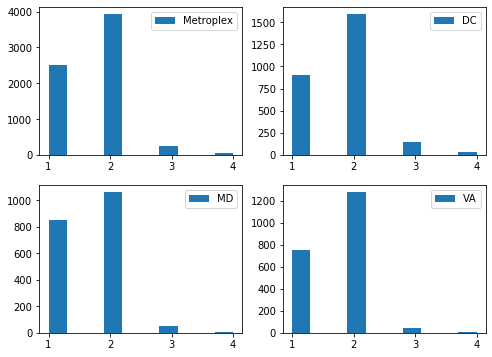

In [61]:
plothist(df_median,median_df)
# similar distribution across all  

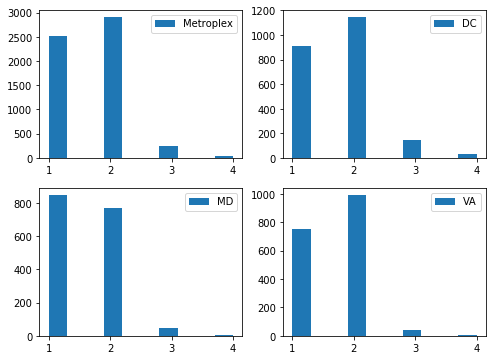

In [62]:
plothist(df_na, na_df)
# similar distribution across all 

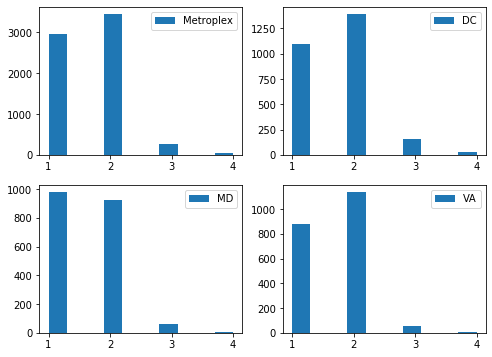

In [65]:
plothist(df_random,random_df)
# distributions the same all across 

In [ ]:
# we will split price into 2 groups so we will perform welch's T test 
# we need to check for normality assumption 

In [ ]:
# df median

In [67]:
# check for normality for review count and rating 
stats.normaltest(df_median.price) # not normal distribution 

NormaltestResult(statistic=161.168335339302, pvalue=1.0063305388340853e-35)

In [68]:
stats.normaltest(df_median.rating) # not normal distribution 

NormaltestResult(statistic=391.5581540679273, pvalue=9.423824117901497e-86)

In [ ]:
# we will use central limit thereom 
# and look at rating mean and review count mean for each price tag

In [69]:
# randomly generate 100 samples for 100000 times 
def boostrap_sample(samples, n):
    return np.random.choice(samples, size = n, replace = True )
# generate sample means
def sampling(samples, n, num):
    sample_means = []
    for i in range(num):
        sample_means.append(boostrap_sample(samples, n).mean())
    return sample_means
# generate 2 samples function for split value 
# split data into high price and low price 
def samples(df, colname, criteria, value):
    '''
    df: a dataframe
    colname: colname of interest for split 
    criteria: an int for filter for colname
    value: colname for actual comparsion 
    return 2 samples of 1 day numpy array, data1 uses mask, data2 complement mask
    '''
    mask = df[colname]>= criteria
    data1 = df[mask].reset_index()[value]
    data2 = df[~mask].reset_index()[value]
    return (data1, data2)

In [70]:
# split into 2 datasets for pricelow and high 
price_splits_review = samples(df_median, 'price', 2, 'review_count')
price_high_review = price_splits_review[0]
price_low_review = price_splits_review[1]

In [71]:
high_means_review = sampling(price_high_review,100,10000)

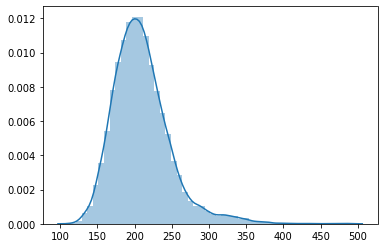

In [72]:
sns.distplot(high_means_review)

In [73]:
low_means_review = np.array(sampling(price_low_review, 100, 10000))

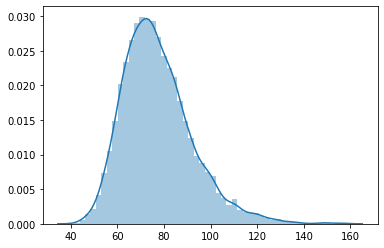

In [74]:
sns.distplot(low_means_review)

In [75]:
stats.ttest_ind(high_means_review, low_means_review, equal_var=False)
# high price restaurant has higher review counts 

Ttest_indResult(statistic=318.02828193010896, pvalue=0.0)

In [76]:
# split using rating 
price_splits_rating = samples(df_median, 'price', 2, 'rating')
price_high_rating = price_splits_rating[0]
price_low_rating = price_splits_rating[1]

In [77]:
high_means_rating = sampling(price_high_rating,100,100000)
low_means_rating = sampling(price_low_rating,100,1000000)

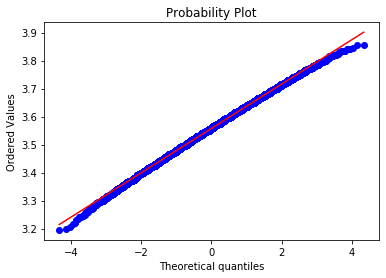

In [78]:
stats.probplot(high_means_rating, dist="norm", plot=plt)
plt.show()

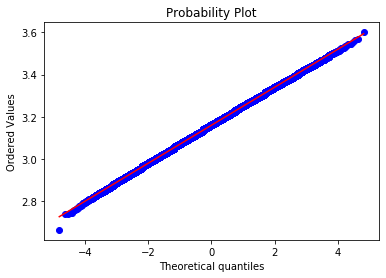

In [79]:
stats.probplot(low_means_rating, dist="norm", plot=plt)
plt.show()

In [80]:
stats.ttest_ind(high_means_rating, low_means_rating, equal_var=False)
# high price restaurant has higher rating 

Ttest_indResult(statistic=1496.610698302983, pvalue=0.0)

In [86]:
def price_welcht(DF, colname, criteria, metric, n, num):
    price_splits = samples(DF, colname, 2, metric)
    price_high = price_splits_review[0]
    price_low = price_splits_review[1]
    # sampling
    high_means = np.array(sampling(price_high_review, n, num))
    low_means = np.array(sampling(price_low_review, n, num))
    return stats.ttest_ind(high_means, low_means, equal_var=False)

In [88]:
display(price_welcht(df_na, 'price', 2, 'review_count', 100, 100000))
price_welcht(df_na, 'price', 2, 'rating', 100, 100000)
# high price tag works better for review count and rating 

Ttest_indResult(statistic=1011.815258520106, pvalue=0.0)

Ttest_indResult(statistic=1011.4471721278982, pvalue=0.0)

In [89]:
# median value 
display(price_welcht(df_median, 'price', 2, 'review_count', 100, 100000))
price_welcht(df_median, 'price', 2, 'rating', 100, 100000)
# high price tag works better in this case 

Ttest_indResult(statistic=1010.0067465524457, pvalue=0.0)

Ttest_indResult(statistic=1016.0574027139359, pvalue=0.0)

In [90]:
# random value
display(price_welcht(df_random, 'price', 2, 'review_count', 100, 100000))
price_welcht(df_random, 'price', 2, 'rating', 100, 100000)

Ttest_indResult(statistic=1012.9169493575149, pvalue=0.0)

Ttest_indResult(statistic=1008.3761842760459, pvalue=0.0)